This notebook looks at the NOAA data off the west coast of BC and US.

In [1]:
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sets import Set
import calendar
import seaborn as sns
import csvWOD

sns.set()

%matplotlib inline

The following cell loads in ALL the WOD13 data off the west coast of BC and the US. There is over 500MB of data parsed here, and so it may take a while (despite csvWOD_readcasts being relatively optimized to read large files).

In [2]:
cast_inf = csvWOD.csvWOD_readcasts("../../5_WOD13_Data/WOD13_002/ocldb1431635442.6176.CTD.csv")
cast_inf.extend(csvWOD.csvWOD_readcasts("../../5_WOD13_Data/WOD13_002/ocldb1431635442.6176.OSD.csv"))

Setup the area to focus in on here, and plot it. For this notebook, we'll focus in on the area around LC12.

In [3]:
### LC12
FOCUS_LON_MIN = -126-(50.0/60.0)
FOCUS_LON_MAX = -126-(20.0/60.0)
FOCUS_LAT_MIN = 48
FOCUS_LAT_MAX = 48+(40.0/60.0)

# ## MB07
# FOCUS_LON_MIN = -125.5
# FOCUS_LON_MAX = -125
# FOCUS_LAT_MIN = 48.2
# FOCUS_LAT_MAX = 48.4

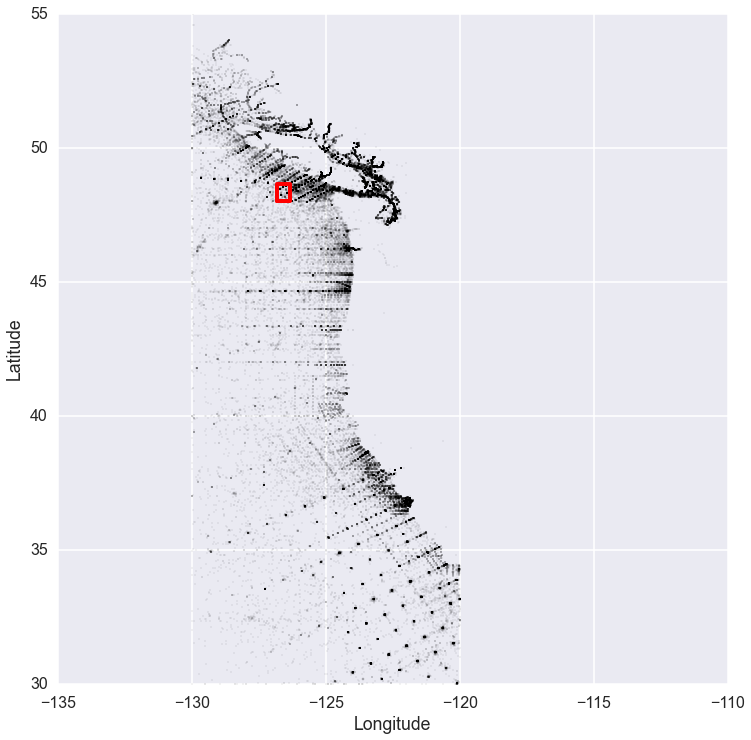

TOTAL CASTS AVAILABLE :  111456
YEARS AVAILABLE       :  1911 --- 2014


In [19]:
plt.figure(figsize=(12,12))

sns.set_style("darkgrid")
sns.set_context("poster")

lats = []
lons = []
yrs = Set([])
for cast in cast_inf:
    if 'Temperatur' in cast['Variables'] and 'Salinity' in cast['Variables']:
        lats.append(cast['Latitude'])
        lons.append(cast['Longitude'])    
        yrs.add(cast['Year'])

plt.plot(lons,lats,'.k',ms=1)
x_bd_box = [FOCUS_LON_MIN,FOCUS_LON_MAX,FOCUS_LON_MAX,FOCUS_LON_MIN,FOCUS_LON_MIN]
y_bd_box = [FOCUS_LAT_MIN,FOCUS_LAT_MIN,FOCUS_LAT_MAX,FOCUS_LAT_MAX,FOCUS_LAT_MIN]
plt.plot(x_bd_box,y_bd_box,'-r',lw=4)
plt.ylim((30,55))
plt.xlim((-135,-110))
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

print "TOTAL CASTS AVAILABLE : ", str(len(lats))
print "YEARS AVAILABLE       : ", str(min(yrs)), "---", str(max(yrs))

Focus in on the area marked by a red rectangle above.

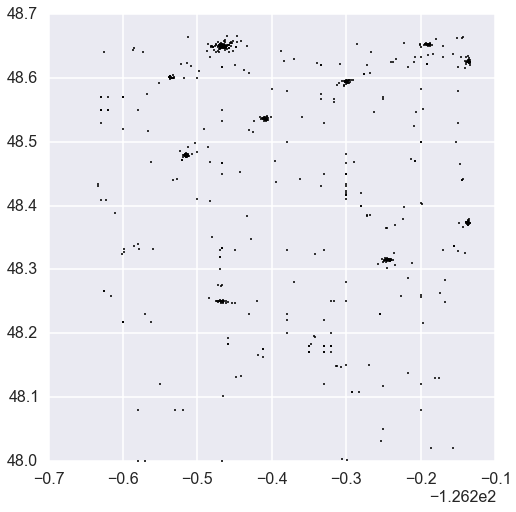

TOTAL NUMBER OF DATASETS:  1123


In [5]:
zm_casts = []

zm_casts = csvWOD.csvWOD_filter_region(cast_inf,FOCUS_LON_MIN,FOCUS_LON_MAX,FOCUS_LAT_MIN,FOCUS_LAT_MAX)

plt.figure(figsize=(8,8))

zm_lons = []
zm_lats = []

for ii in range(0,len(zm_casts)):
    zm_lons.append(zm_casts[ii]['Longitude'])
    zm_lats.append(zm_casts[ii]['Latitude'])
    
plt.plot(zm_lons,zm_lats,'.k',ms=4)
plt.show()

print "TOTAL NUMBER OF DATASETS: ", str(len(zm_casts))

The following cell splits up all the data into months, and plots it out. It shows the relative amount of data available for each month of the year.

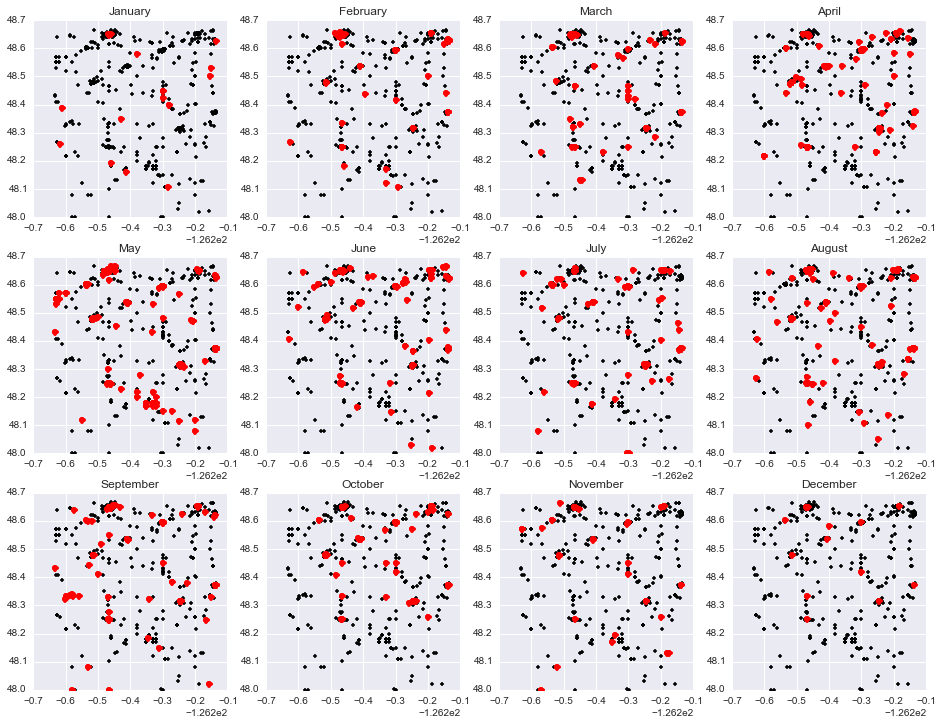

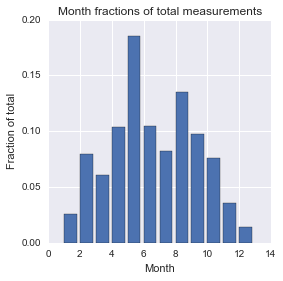

In [6]:
mnth_fracs = []

sns.set_context('notebook')
plt.figure(figsize=(16,12))
for mnth in range(1,13):
    plt.subplot(3,4,mnth)
    mnth_filt = csvWOD.csvWOD_filter_month(zm_casts,mnth)

    mnth_lons = []
    mnth_lats = []
    for ii in range(0,len(mnth_filt)):
        mnth_lons.append(mnth_filt[ii]['Longitude'])
        mnth_lats.append(mnth_filt[ii]['Latitude'])
    plt.plot(zm_lons,zm_lats,'.k')
    plt.plot(mnth_lons,mnth_lats,'or')
    plt.title(calendar.month_name[mnth])

    mnth_fracs.append(float(len(mnth_filt))/float(len(zm_casts)))

plt.figure(figsize=(4,4))
plt.bar(np.arange(1,13),mnth_fracs)
plt.title('Month fractions of total measurements')
plt.xlabel('Month')
plt.ylabel('Fraction of total')
plt.show()

sns.set_context('poster')

Now look at how the TS properties change over the course of a year. The data used here is over a very large span of time.

In [13]:
def temp_from_saln_bins(bins,saln,temp):
    '''
    temp_from_saln_bins
    Args:
    bins      -- an array of bin edges, i.e. (0,1,2,3,4) would create 4 bins: 0-1, 1-2, 2-3, 3-4
    saln -- all salinity data points
    temp -- all temperature data points
    '''
    
    # digitized bins the saln values based on the bins array
    # i.e. index 'n' of saln array belongs to bin digi_saln[n]
    digi_saln = np.digitize(saln, bins)

    # initialized the digitized temperature list
    bin_temp = []
    for ii in range(0,len(bins)):
        bin_temp.append([])

    # loop through the 
    for ii in range(0,len(digi_saln)):
        # make sure the bin num. is within acceptable range and is a number
        if digi_saln[ii] < len(bins) and ~np.isnan(temp[ii]):
            # append this temperature to the bin_temp data
            bin_temp[digi_saln[ii]].append(temp[ii])
    
    # do statistics to get the mean and standard deviation of each bin
    mean_tmp_bins = []
    std_tmp_bins = []
    for ii in range(0,len(bins)):
        mean_tmp_bins.append(np.mean(bin_temp[ii]))
        std_tmp_bins.append(np.std(bin_temp[ii]))
    
    # return the statistical data
    return mean_tmp_bins,std_tmp_bins

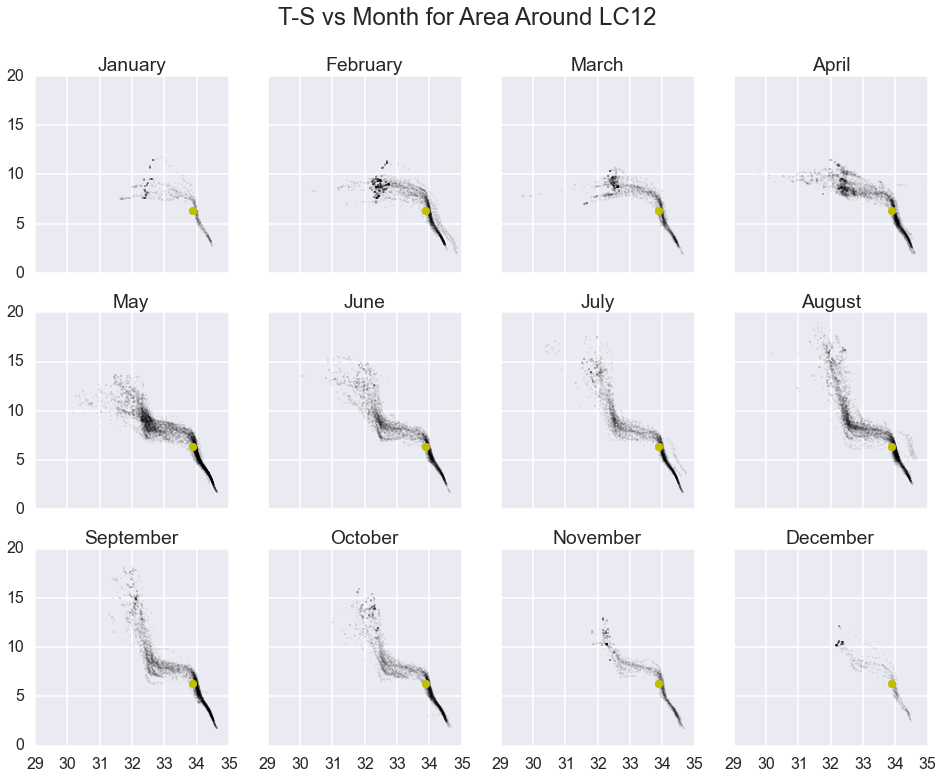

DATA FROM:  1936 --- 2009


In [24]:
fig,axes=plt.subplots(3,4,figsize=(16,12),sharex=True,sharey=True)

dat_set = csvWOD.csvWOD_filter_variables(zm_casts,['Temperatur','Salinity'])
#dat_set = csvWOD.csvWOD_filter_year(dat_set,1990,2015)

all_yrs = Set([])

saln_bins = np.linspace(29,35,40)
mean_temp_bins = []
std_temp_bins = []

for cnt,row in enumerate(axes):
    for cnt2,ax in enumerate(row):
        mnth = (cnt*4)+cnt2+1
        #plt.subplot(3,4,mnth)
        mnth_filt = csvWOD.csvWOD_filter_month(dat_set,mnth)
    
        #mnth_lons = []
        #mnth_lats = []
        mnth_temp = []
        mnth_saln = []
        for ii in range(0,len(mnth_filt)):
            all_yrs.add(mnth_filt[ii]['Year'])
            #mnth_lons.append(mnth_filt[ii]['Longitude'])
            #mnth_lats.append(mnth_filt[ii]['Latitude'])
            mnth_temp.extend(mnth_filt[ii]['Temperatur'])
            mnth_saln.extend(mnth_filt[ii]['Salinity'])
        #plt.plot(zm_lons,zm_lats,'.k')
        A,B = temp_from_saln_bins(saln_bins,mnth_saln,mnth_temp)
        mean_temp_bins.append(np.array(A))
        std_temp_bins.append(np.array(B))
        
        ax.plot(mnth_saln,mnth_temp,'.k',ms=1)
        #ax.plot(saln_bins,mean_temp_bins[-1],'-')
        #ax.fill_between(saln_bins,mean_temp_bins[-1]-std_temp_bins[-1],mean_temp_bins[-1]+std_temp_bins[-1],alpha=0.3)
        ax.plot(33.9,6.3,'oy',ms=8)
        ax.set_xlim((29,35))
        ax.set_ylim((0,20))
        ax.set_title(calendar.month_name[mnth])
        
plt.suptitle('T-S vs Month for Area Around LC12',fontsize=24)
#plt.supxlabel('S')
#plt.supylabel('T')
plt.show()

print "DATA FROM: ", str(min(all_yrs)), "---", str(max(all_yrs))

The above plots give a general idea of how offshore TS properties change over the course of a year.

###EVOLUTION OF T-S THROUGHOUT YEAR (AVERAGE)###

Here, we group the binned data curves into three distinct parts of the year; winter, transition, and summer.

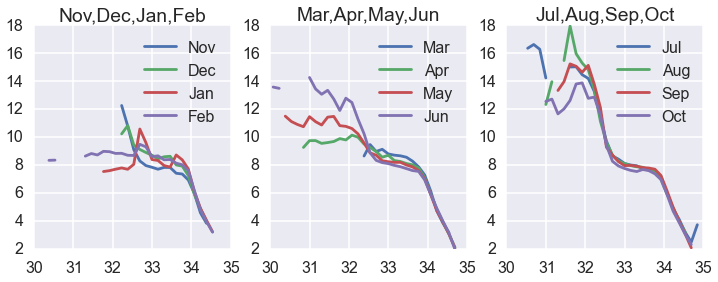

In [17]:
plt.figure(figsize=(12,4))

plt.subplot(1,3,1)
for ii in [10,11,0,1]:
    plt.plot(saln_bins,mean_temp_bins[ii],label=calendar.month_abbr[ii+1])
plt.legend()
plt.xlim((30,35))
plt.ylim((2,18))
plt.title('Nov,Dec,Jan,Feb')

plt.subplot(1,3,2)
for ii in [2,3,4,5]:
    plt.plot(saln_bins,mean_temp_bins[ii],label=calendar.month_abbr[ii+1])
plt.legend()
plt.xlim((30,35))
plt.ylim((2,18))
plt.title('Mar,Apr,May,Jun')

plt.subplot(1,3,3)
for ii in [6,7,8,9]:
    plt.plot(saln_bins,mean_temp_bins[ii],label=calendar.month_abbr[ii+1])
    
plt.legend()
plt.xlim((30,35))
plt.ylim((2,18))
plt.title('Jul,Aug,Sep,Oct')

plt.show()


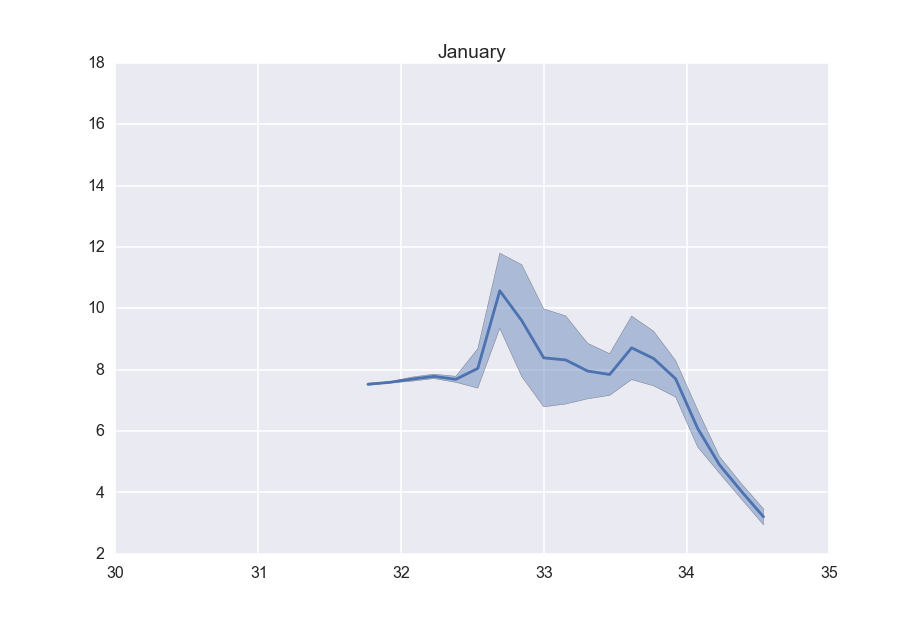
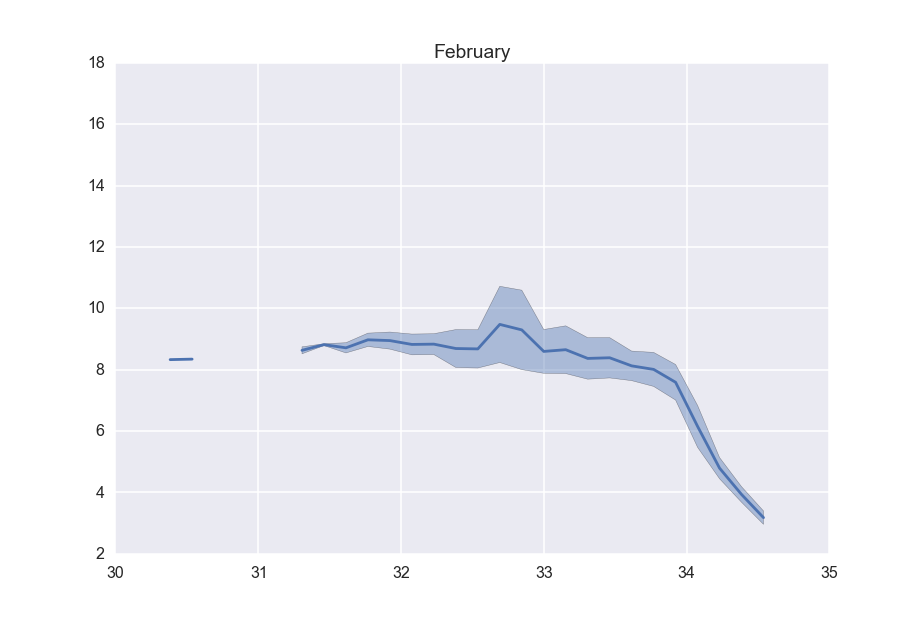
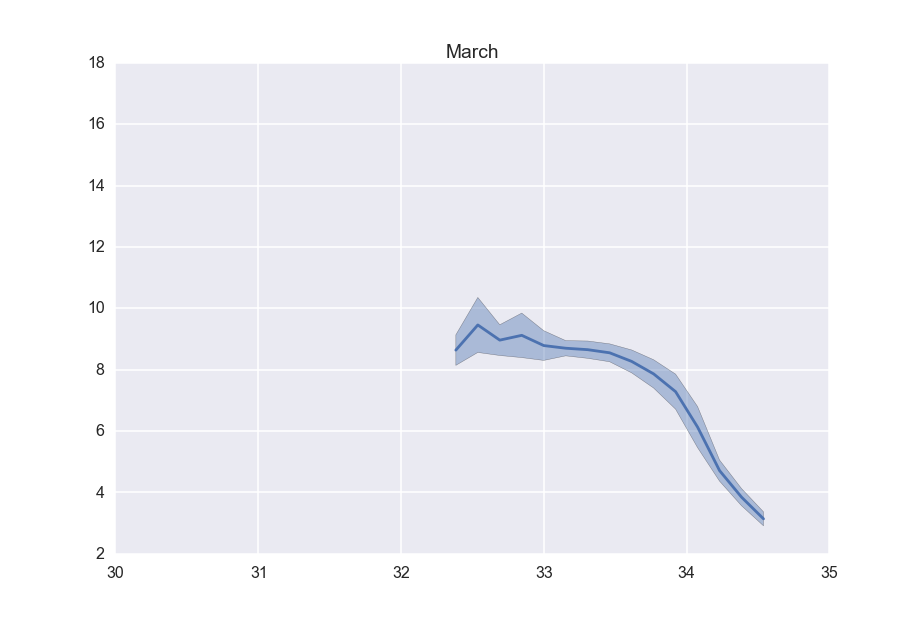
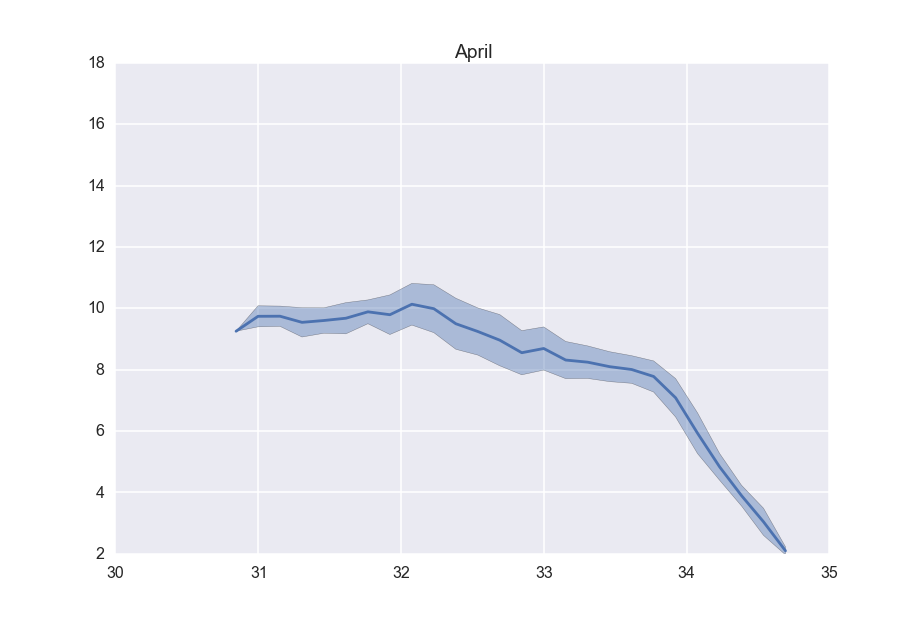
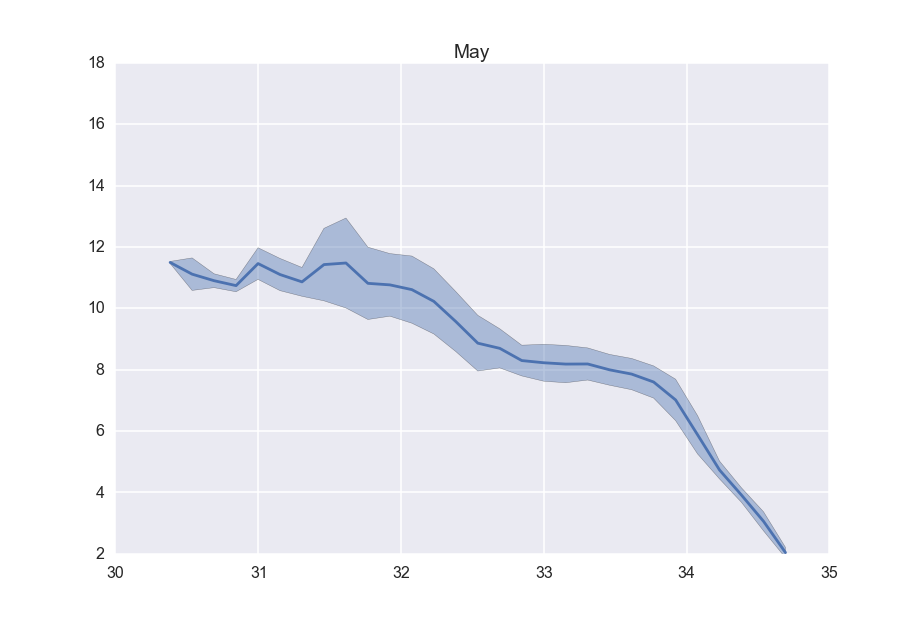
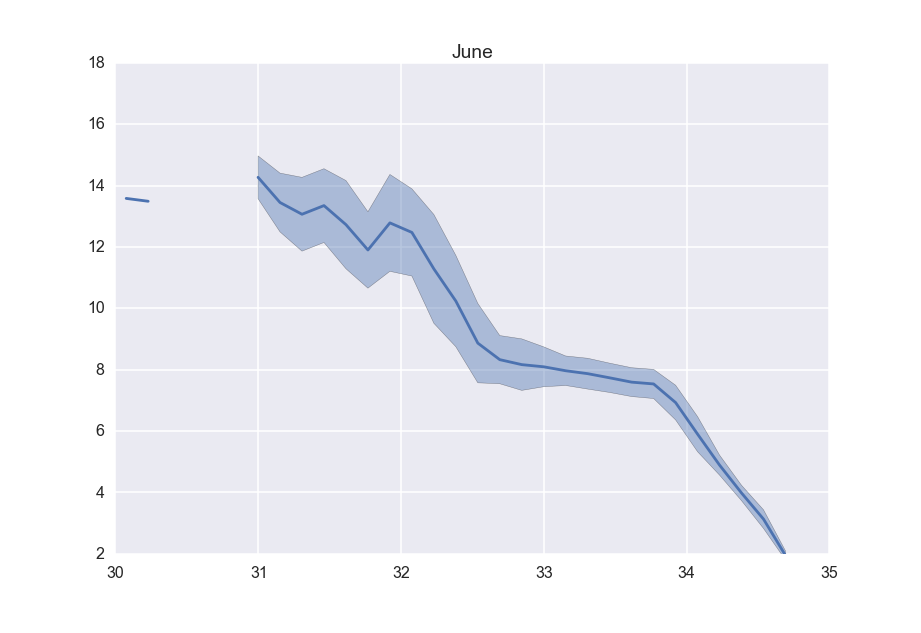
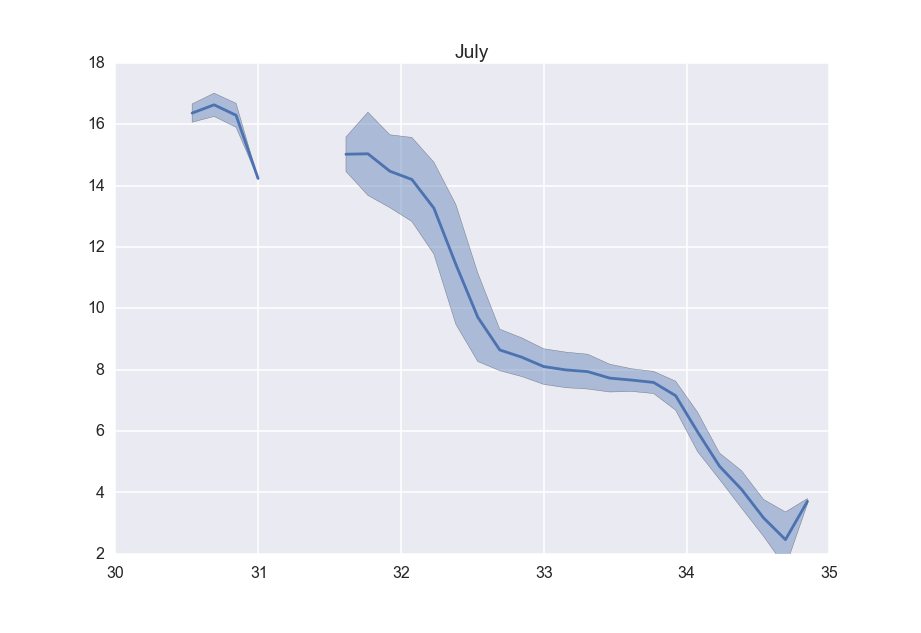
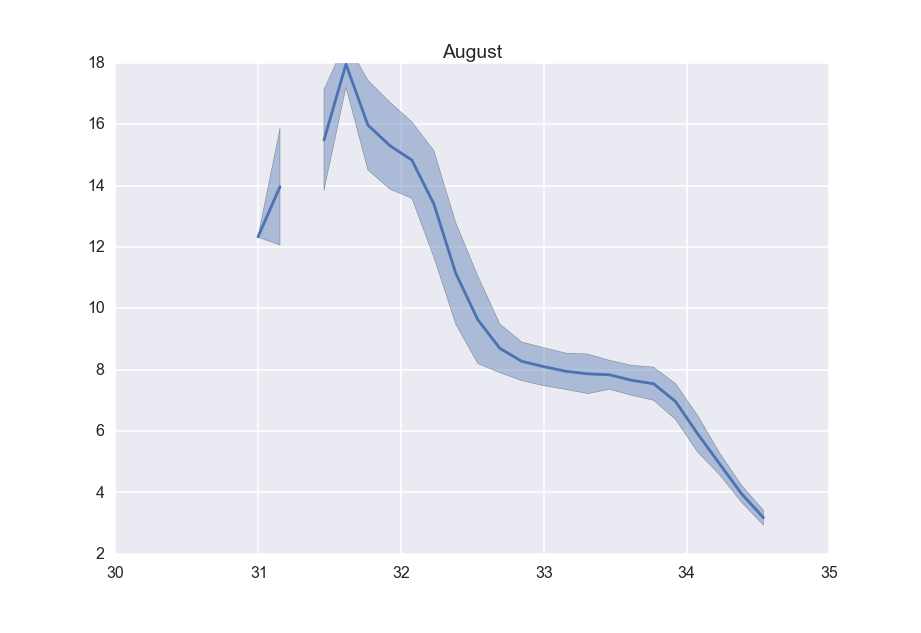
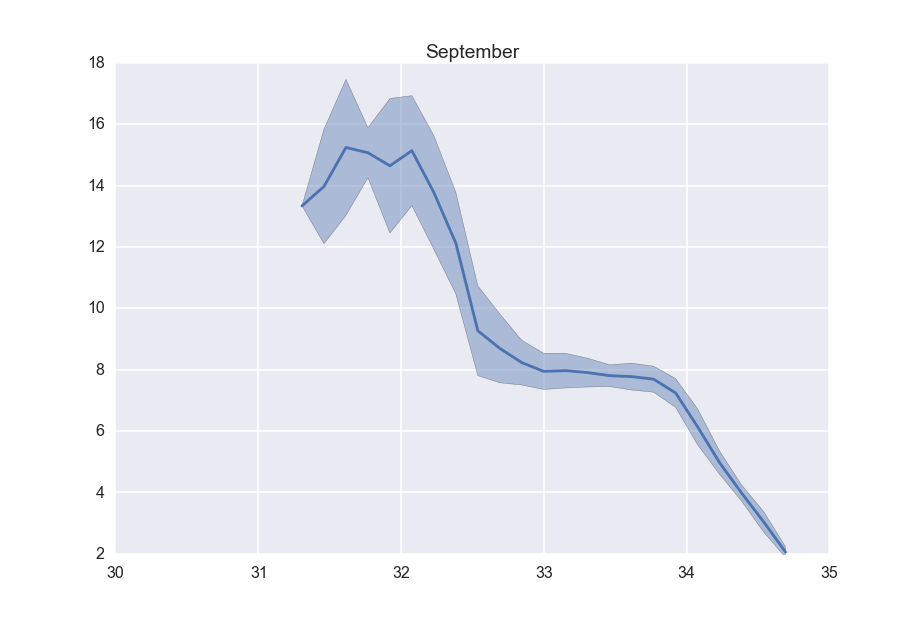
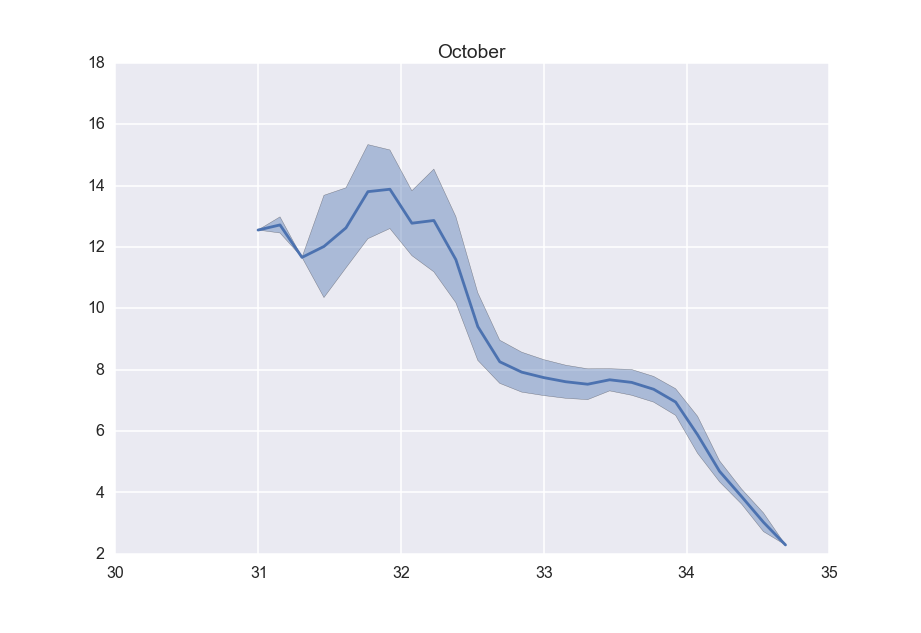
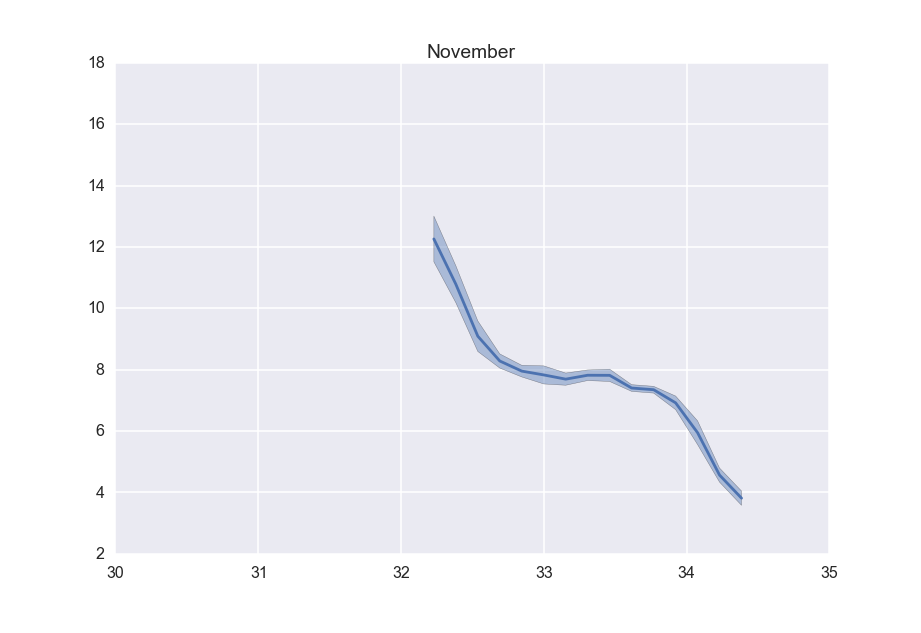
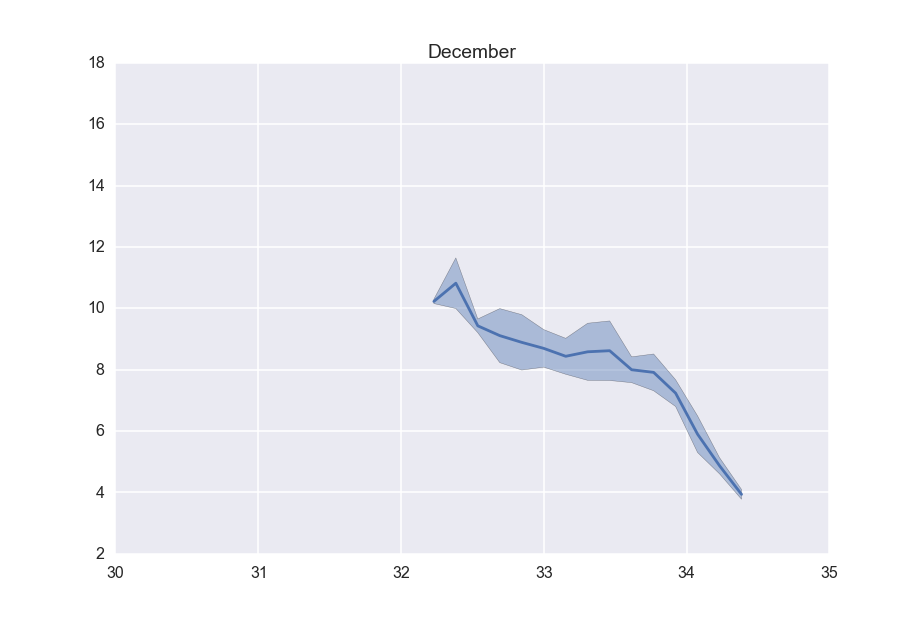

In [18]:
from matplotlib import animation
from JSAnimation import IPython_display

fig = plt.figure()
ax = plt.axes(xlim=(30,35), ylim=(2,18))
line, = ax.plot([], [], lw=2)

def init():
    line.set_data([], [])
    return line,

def animate(i):
    ax.cla()
    ax.plot(saln_bins,mean_temp_bins[i])
    ax.fill_between(saln_bins,mean_temp_bins[i]+std_temp_bins[i],mean_temp_bins[i]-std_temp_bins[i],alpha=0.4)
    ax.set_xlim((30,35))
    ax.set_ylim((2,18))
    ax.set_title(calendar.month_name[i+1])
    return line,

animation.FuncAnimation(fig, animate, init_func=init,
                        frames=12,interval=500)